In [1]:
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
import numpy as np
import seaborn as sns

In [2]:
results_dir = pathlib.Path('results')

plot_data = []
for p in (results_dir / 'flora').iterdir():
    if p.is_dir():
        # parse the directory name
        args = p.name.split('-')
        if len(args) <= 1:
            continue

        # get the args from the dir name
        rand_distribution = None
        rank = None
        clip_norm = None
        for arg in args:
            if arg.startswith('rand_distribution_'):
                rand_distribution = arg[len('rand_distribution_'):]
            elif arg.startswith('rank_'):
                rank = int(arg[len('rank_'):])
            elif arg.startswith('clip_norm_'):
                clip_norm = (arg[len('clip_norm_'):] == 'True')
        if rand_distribution is None or rank is None or clip_norm is None:
            continue

        # load the losses
        train_losses = np.load(p / 'train_losses.npy')
        validation_losses = np.load(p / 'validation_losses.npy')
        df_train = pd.DataFrame({
            'loss_type': 'train',
            'loss': train_losses / train_losses[0],
            'rand_distribution': rand_distribution,
            'rank': rank,
            'clip_norm': clip_norm,
            'epoch': np.arange(len(train_losses))
        })

        df_validation = pd.DataFrame({
            'loss_type': 'validation',
            'loss': validation_losses / validation_losses[0],
            'rand_distribution': rand_distribution,
            'rank': rank,
            'clip_norm': clip_norm,
            'epoch': np.arange(len(validation_losses))
        })

        plot_data.append(df_train)
        plot_data.append(df_validation)

plot_data = pd.concat(plot_data)
plot_data

,loss_type,loss,rand_distribution,rank,clip_norm,epoch
0,train,1.000000,normal,8,False,0
1,train,0.999678,normal,8,False,1
2,train,0.999337,normal,8,False,2
3,train,0.998997,normal,8,False,3
4,train,0.998661,normal,8,False,4
...,...,...,...,...,...,...
9995,validation,0.150461,discrete_3,256,True,9995
9996,validation,0.150445,discrete_3,256,True,9996
9997,validation,0.150429,discrete_3,256,True,9997
9998,validation,0.150414,discrete_3,256,True,9998


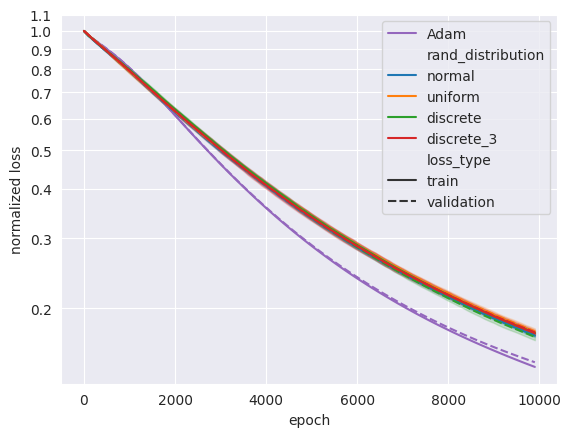

In [3]:
adam_train_losses = np.load(results_dir / 'adam' / 'clip_norm_False-20250612_154706' / 'train_losses.npy')
adam_validation_losses = np.load(results_dir / 'adam' / 'clip_norm_False-20250612_154706' / 'validation_losses.npy')
fig, ax = plt.subplots()
ax.plot(np.arange(0, len(adam_train_losses), 100), adam_train_losses[::100] / adam_train_losses[0], label='Adam', color='tab:purple')
ax.plot(np.arange(0, len(adam_validation_losses), 100), adam_validation_losses[::100] / adam_validation_losses[0], linestyle='dashed', color='tab:purple')
sns.lineplot(
    data=plot_data[(plot_data['rank'] == 8) & (~plot_data['clip_norm'])][::100],
    x='epoch',
    y='loss',
    hue='rand_distribution',
    style='loss_type',
    ax=ax,
)
ax.set(yscale='log')
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('normalized loss')
fig.savefig('rand_projections.pdf', bbox_inches='tight')

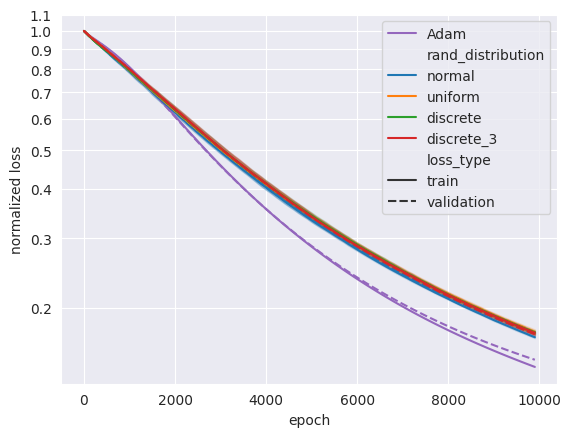

In [4]:
adam_train_losses = np.load(results_dir / 'adam' / 'clip_norm_True-20250612_154749' / 'train_losses.npy')
adam_validation_losses = np.load(results_dir / 'adam' / 'clip_norm_True-20250612_154749' / 'validation_losses.npy')
fig, ax = plt.subplots()
ax.plot(np.arange(0, len(adam_train_losses), 100), adam_train_losses[::100] / adam_train_losses[0], label='Adam', color='tab:purple')
ax.plot(np.arange(0, len(adam_validation_losses), 100), adam_validation_losses[::100] / adam_validation_losses[0], linestyle='dashed', color='tab:purple')
sns.lineplot(
    data=plot_data[(plot_data['rank'] == 8) & (plot_data['clip_norm'])][::100],
    x='epoch',
    y='loss',
    hue='rand_distribution',
    style='loss_type',
    ax=ax,
)
ax.set(yscale='log')
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('normalized loss')
fig.savefig('grad_clip.pdf', bbox_inches='tight')

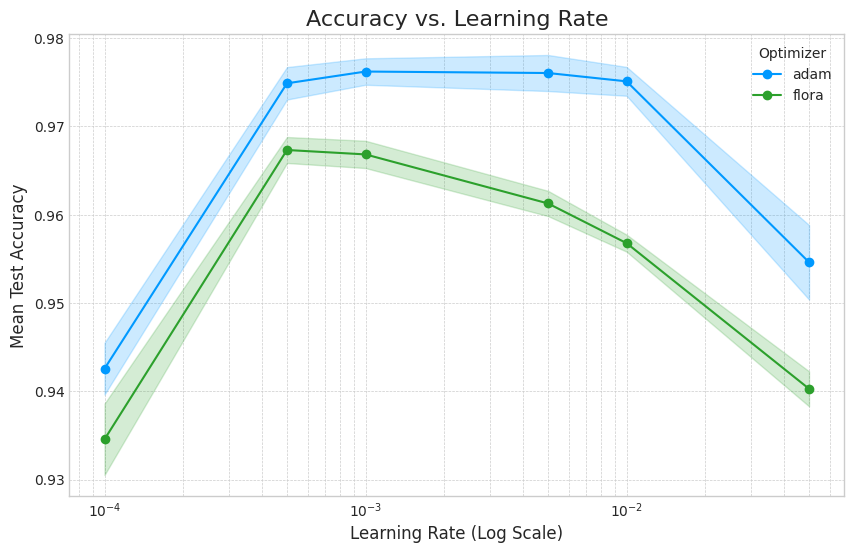

In [12]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Configuration ---

# Set the base path to your results directory
BASE_RESULTS_PATH = pathlib.Path('results-lr')

# Define the optimizers you want to plot
OPTIMIZERS = ['adam', 'flora']

# Define colors for each optimizer
COLORS = {'adam': '#0099ff', 'flora': '#2ca02c'}

# V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V
# EDIT THESE LISTS to specify which learning rates and seeds to include
TESTED_LRS = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
TESTED_SEEDS = [42, 123, 888]
# ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^

# --- 1. Data Aggregation ---

aggregated_accuracies = defaultdict(lambda: defaultdict(list))

# Loop through each optimizer directory
for optimizer in OPTIMIZERS:
    optimizer_path = BASE_RESULTS_PATH / optimizer
    if not optimizer_path.is_dir():
        print(f"Warning: Directory not found for optimizer '{optimizer}', skipping.")
        continue

    # Loop through each individual experiment run directory
    for run_dir in optimizer_path.iterdir():
        if not run_dir.is_dir():
            continue

        # --- NEW PARSING METHOD (as requested) ---
        parts = run_dir.name.split('-')
        
        # Initialize variables to None
        lr = None
        seed = None

        # Loop through each part of the directory name (e.g., 'lr_0.001', 'seed_42')
        for part in parts:
            try:
                if part.startswith('lr_'):
                    lr = float(part[len('lr_'):])
                elif part.startswith('seed_'):
                    seed = int(part[len('seed_'):])
            except (ValueError, TypeError):
                print(f"Warning: Could not parse value from '{part}' in directory '{run_dir.name}'. Skipping this directory.")
                # Set both to None to ensure this directory is skipped
                lr, seed = None, None
                break
        
        # If we couldn't find both a learning rate and a seed, skip this directory
        if lr is None or seed is None:
            continue
        # --- END OF NEW PARSING METHOD ---


        # Filter based on the predefined lists
        if lr not in TESTED_LRS or seed not in TESTED_SEEDS:
            continue

        # If the run passes the filter, load its data
        acc_file = run_dir / "validation_accs.npy"
        if acc_file.exists():
            try:
                accs = np.load(acc_file)
                final_accuracy = accs[-1] # Use the final accuracy
                aggregated_accuracies[optimizer][lr].append(final_accuracy)
            except Exception as e:
                print(f"Error loading or processing {acc_file}: {e}")


# --- 2. Data Processing for Plotting ---
# (This section remains unchanged)
plot_data = defaultdict(lambda: {'lrs': [], 'means': [], 'stds': []})
for optimizer, lr_data in aggregated_accuracies.items():
    sorted_lrs = sorted(lr_data.keys())
    for lr in sorted_lrs:
        accuracies = lr_data[lr]
        if len(accuracies) > 0:
            plot_data[optimizer]['lrs'].append(lr)
            plot_data[optimizer]['means'].append(np.mean(accuracies))
            plot_data[optimizer]['stds'].append(np.std(accuracies))
        else:
             print(f"Warning: No valid runs found for {optimizer} with lr={lr} after filtering.")

# --- 3. Plotting ---
# (This section remains unchanged)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
for optimizer, data in plot_data.items():
    lrs = np.array(data['lrs'])
    means = np.array(data['means'])
    stds = np.array(data['stds'])
    color = COLORS.get(optimizer, 'black')
    ax.plot(lrs, means, marker='o', linestyle='-', label=optimizer, color=color)
    ax.fill_between(lrs, means - stds, means + stds, color=color, alpha=0.2)

# --- 4. Final Touches ---
# (This section remains unchanged)
ax.set_xscale('log')
ax.set_title('Accuracy vs. Learning Rate', fontsize=16)
ax.set_xlabel('Learning Rate (Log Scale)', fontsize=12)
ax.set_ylabel('Mean Test Accuracy', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title='Optimizer')
plt.show()
fig.savefig('learning_rate.pdf', bbox_inches='tight')

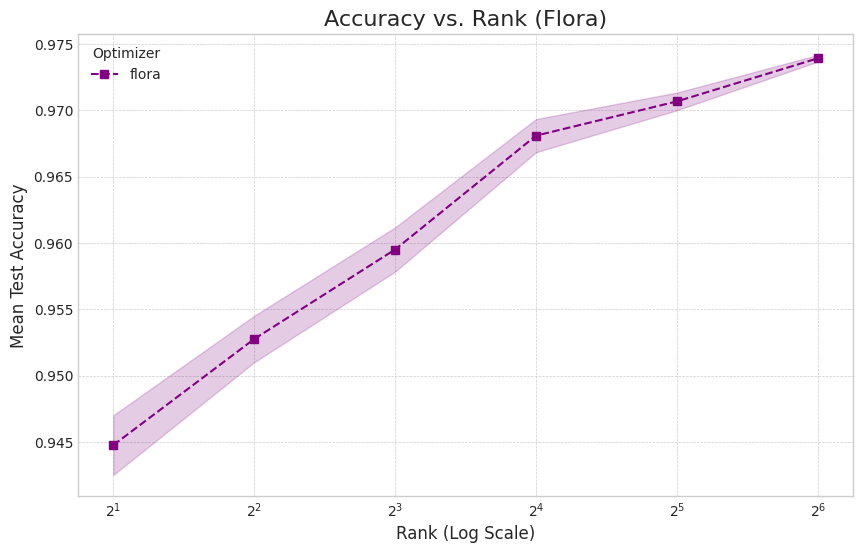

In [14]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Configuration ---

# Set the base path to your results directory
# The script will look inside 'results/flora/'
BASE_RESULTS_PATH = pathlib.Path('results-r')

# Define the optimizer(s) you want to plot
OPTIMIZERS = ['flora']

# Define the visual style for the plot
# You can easily change color, marker style, and line style here
STYLES = {
    'flora': {
        'color': '#800080',  # Purple
        'marker': 's',       # Square
        'linestyle': 'dashed'
    }
}

# V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V
# EDIT THESE LISTS to specify which ranks and seeds to include
TESTED_RANKS = [2, 4, 8, 16, 32, 64]  # Example ranks (2^1 to 2^6)
TESTED_SEEDS = [42, 123, 888]        # Example seeds
# ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^


# --- 1. Data Aggregation ---

# This will store accuracies grouped by optimizer and rank:
# {optimizer: {rank: [acc1, acc2, ...]}}
aggregated_accuracies = defaultdict(lambda: defaultdict(list))

# Loop through each optimizer directory (in this case, just 'flora')
for optimizer in OPTIMIZERS:
    optimizer_path = BASE_RESULTS_PATH / optimizer
    if not optimizer_path.is_dir():
        print(f"Warning: Directory not found for optimizer '{optimizer}', skipping.")
        continue

    # Loop through each individual experiment run directory
    for run_dir in optimizer_path.iterdir():
        if not run_dir.is_dir():
            continue

        # Use the string-splitting method to parse parameters
        parts = run_dir.name.split('-')
        
        rank = None
        seed = None

        # Loop through each part of the directory name (e.g., 'rank_8', 'seed_42')
        for part in parts:
            try:
                if part.startswith('rank_'):
                    rank = int(part[len('rank_'):])
                elif part.startswith('seed_'):
                    seed = int(part[len('seed_'):])
            except (ValueError, TypeError):
                print(f"Warning: Could not parse value from '{part}' in '{run_dir.name}'. Skipping.")
                rank, seed = None, None
                break
        
        # If we couldn't find both a rank and a seed, skip this directory
        if rank is None or seed is None:
            continue

        # Filter based on the predefined lists of ranks and seeds
        if rank not in TESTED_RANKS or seed not in TESTED_SEEDS:
            continue

        # If the run passes the filter, load its accuracy data
        acc_file = run_dir / "validation_accs.npy"
        if acc_file.exists():
            try:
                accs = np.load(acc_file)
                final_accuracy = accs[-1] # Use the final accuracy
                aggregated_accuracies[optimizer][rank].append(final_accuracy)
            except Exception as e:
                print(f"Error loading or processing {acc_file}: {e}")

# --- 2. Data Processing for Plotting ---
plot_data = defaultdict(lambda: {'ranks': [], 'means': [], 'stds': []})

for optimizer, rank_data in aggregated_accuracies.items():
    # Sort by rank to ensure the line plot connects points correctly
    sorted_ranks = sorted(rank_data.keys())
    
    for rank in sorted_ranks:
        accuracies = rank_data[rank]
        if len(accuracies) > 0:
            plot_data[optimizer]['ranks'].append(rank)
            plot_data[optimizer]['means'].append(np.mean(accuracies))
            plot_data[optimizer]['stds'].append(np.std(accuracies))
        else:
             print(f"Warning: No valid runs found for {optimizer} with rank={rank} after filtering.")

# --- 3. Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

for optimizer, data in plot_data.items():
    ranks = np.array(data['ranks'])
    means = np.array(data['means'])
    stds = np.array(data['stds'])
    style = STYLES.get(optimizer, {}) # Get style or empty dict
    
    # Plot the mean accuracy line with specified styles
    ax.plot(
        ranks,
        means,
        label=optimizer,
        color=style.get('color'),
        marker=style.get('marker'),
        linestyle=style.get('linestyle')
    )
    
    # Create the shaded area for variance (mean ± std)
    ax.fill_between(
        ranks,
        means - stds,
        means + stds,
        color=style.get('color'),
        alpha=0.2
    )

# --- 4. Final Touches ---

# Set the x-axis to a logarithmic scale with base 2
ax.set_xscale('log', base=2)

# Set labels and title to match the example image
ax.set_title('Accuracy vs. Rank (Flora)', fontsize=16)
ax.set_xlabel('Rank (Log Scale)', fontsize=12)
ax.set_ylabel('Mean Test Accuracy', fontsize=12)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add the legend
ax.legend(title='Optimizer')

plt.show()
fig.savefig('rank.pdf', bbox_inches='tight')

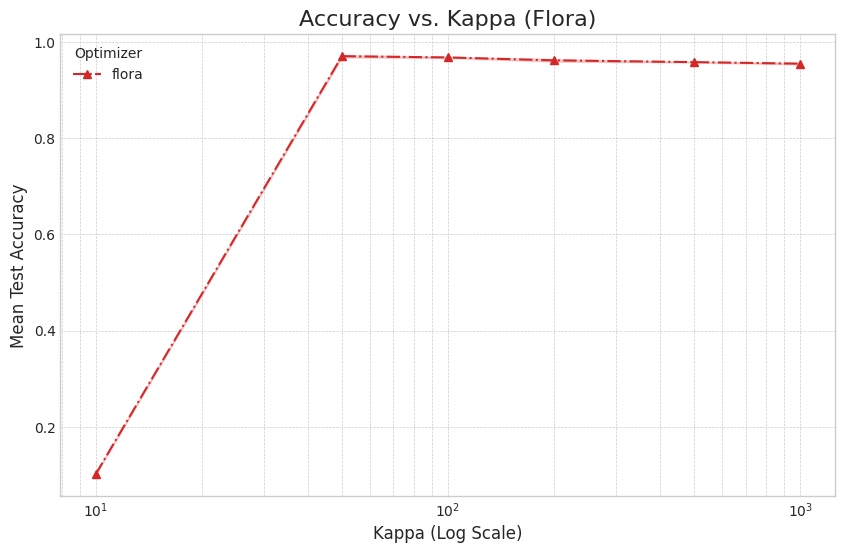

In [17]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Configuration ---

# Set the base path to your results directory
# The script will look inside 'results/flora/'
BASE_RESULTS_PATH = pathlib.Path('results-kappa')

# Define the optimizer(s) you want to plot
OPTIMIZERS = ['flora']

# Define the visual style for the plot to match the example
STYLES = {
    'flora': {
        'color': '#d62728',  # A shade of red
        'marker': '^',       # Triangle up
        'linestyle': '-.'    # Dash-dot line
    }
}

# V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V
# EDIT THESE LISTS to specify which kappas and seeds to include
TESTED_KAPPAS = [10, 50, 100, 200, 500, 1000] # Example kappa values
TESTED_SEEDS = [42, 123, 888]               # Example seeds
# ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^


# --- 1. Data Aggregation ---

# This will store accuracies grouped by optimizer and kappa:
# {optimizer: {kappa: [acc1, acc2, ...]}}
aggregated_accuracies = defaultdict(lambda: defaultdict(list))

# Loop through each optimizer directory
for optimizer in OPTIMIZERS:
    optimizer_path = BASE_RESULTS_PATH / optimizer
    if not optimizer_path.is_dir():
        print(f"Warning: Directory not found for optimizer '{optimizer}', skipping.")
        continue

    # Loop through each individual experiment run directory
    for run_dir in optimizer_path.iterdir():
        if not run_dir.is_dir():
            continue

        # Use the string-splitting method to parse parameters
        parts = run_dir.name.split('-')
        
        kappa = None
        seed = None

        # Loop through each part of the directory name (e.g., 'kappa_10', 'seed_1')
        for part in parts:
            try:
                if part.startswith('kappa_'):
                    # Use float() for safety, as kappa could be a decimal
                    kappa = float(part[len('kappa_'):])
                elif part.startswith('seed_'):
                    seed = int(part[len('seed_'):])
            except (ValueError, TypeError):
                print(f"Warning: Could not parse value from '{part}' in '{run_dir.name}'. Skipping.")
                kappa, seed = None, None
                break
        
        # If we couldn't find both kappa and seed, skip this directory
        if kappa is None or seed is None:
            continue

        # Filter based on the predefined lists of kappas and seeds
        if kappa not in TESTED_KAPPAS or seed not in TESTED_SEEDS:
            continue

        # If the run passes the filter, load its accuracy data
        acc_file = run_dir / "validation_accs.npy"
        if acc_file.exists():
            try:
                accs = np.load(acc_file)
                final_accuracy = accs[-1] # Use the final accuracy
                aggregated_accuracies[optimizer][kappa].append(final_accuracy)
            except Exception as e:
                print(f"Error loading or processing {acc_file}: {e}")

# --- 2. Data Processing for Plotting ---
plot_data = defaultdict(lambda: {'kappas': [], 'means': [], 'stds': []})

for optimizer, kappa_data in aggregated_accuracies.items():
    # Sort by kappa to ensure the line plot connects points correctly
    sorted_kappas = sorted(kappa_data.keys())
    
    for kappa in sorted_kappas:
        accuracies = kappa_data[kappa]
        if len(accuracies) > 0:
            plot_data[optimizer]['kappas'].append(kappa)
            plot_data[optimizer]['means'].append(np.mean(accuracies))
            plot_data[optimizer]['stds'].append(np.std(accuracies))
        else:
             print(f"Warning: No valid runs found for {optimizer} with kappa={kappa} after filtering.")

# --- 3. Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

for optimizer, data in plot_data.items():
    kappas = np.array(data['kappas'])
    means = np.array(data['means'])
    stds = np.array(data['stds'])
    style = STYLES.get(optimizer, {})
    
    # Plot the mean accuracy line with specified styles
    ax.plot(
        kappas,
        means,
        label=optimizer,
        color=style.get('color'),
        marker=style.get('marker'),
        linestyle=style.get('linestyle')
    )
    
    # Create the shaded area for variance
    ax.fill_between(
        kappas,
        means - stds,
        means + stds,
        color=style.get('color'),
        alpha=0.2
    )

# --- 4. Final Touches ---

# Set the x-axis to a standard logarithmic scale (base 10)
ax.set_xscale('log')

# Set labels and title to match the example image
ax.set_title('Accuracy vs. Kappa (Flora)', fontsize=16)
ax.set_xlabel('Kappa (Log Scale)', fontsize=12)
ax.set_ylabel('Mean Test Accuracy', fontsize=12)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add the legend
ax.legend(title='Optimizer')

plt.show()
fig.savefig('kappa.pdf', bbox_inches='tight')

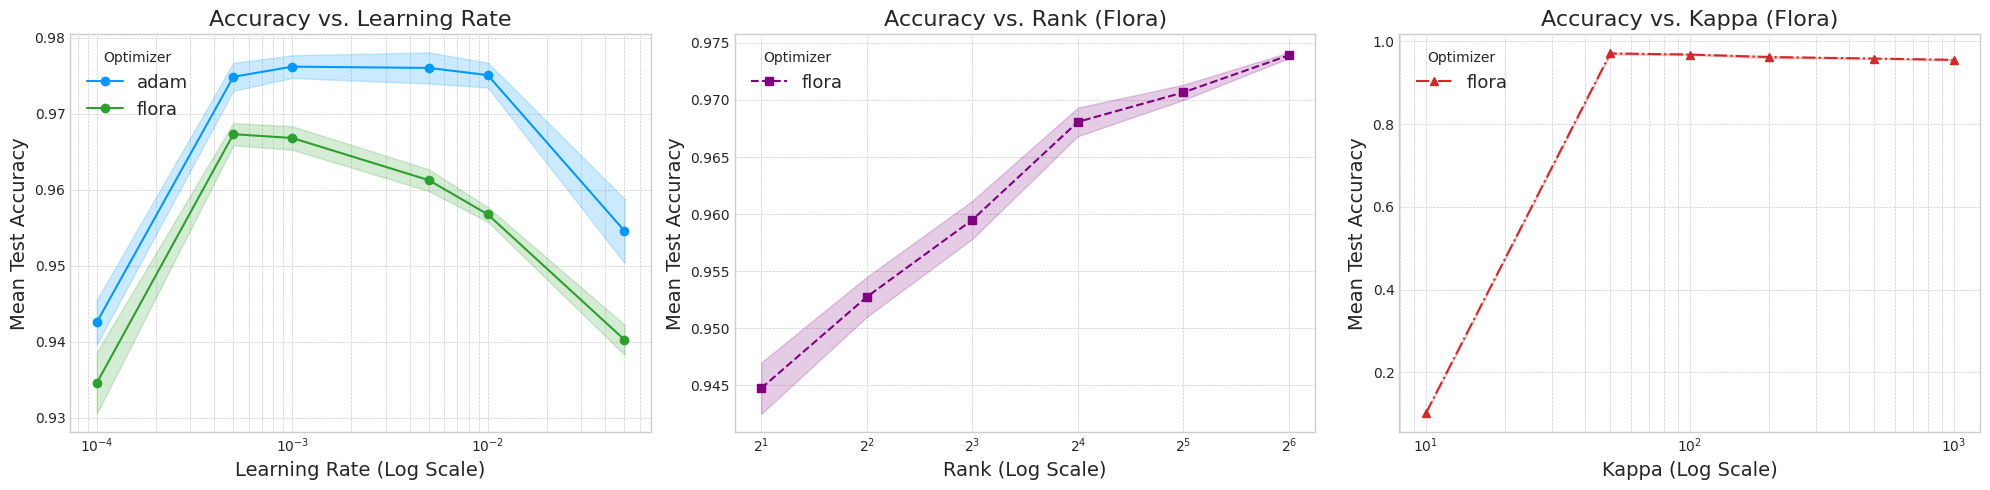

In [35]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Main Configuration ---
TESTED_SEEDS = [42, 123, 888]

# --- Plot 1: Learning Rate ---
LR_CONFIG = {
    'base_path': pathlib.Path('results-lr'),
    'param_name': 'lr',
    'optimizers': ['adam', 'flora'], # Using adamw from the image
    'tested_params': [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'styles': {'adam': {'color': '#0099ff', 'marker': 'o', 'linestyle': '-'},
               'flora': {'color': '#2ca02c', 'marker': 'o', 'linestyle': '-'}},
    'title': 'Accuracy vs. Learning Rate',
    'xlabel': 'Learning Rate (Log Scale)',
    'log_base': 10
}

# --- Plot 2: Rank ---
RANK_CONFIG = {
    'base_path': pathlib.Path('results-r'),
    'param_name': 'rank',
    'optimizers': ['flora'],
    'tested_params': [2, 4, 8, 16, 32, 64],
    'styles': {'flora': {'color': '#800080', 'marker': 's', 'linestyle': 'dashed'}},
    'title': 'Accuracy vs. Rank (Flora)',
    'xlabel': 'Rank (Log Scale)',
    'log_base': 2
}

# --- Plot 3: Kappa ---
KAPPA_CONFIG = {
    'base_path': pathlib.Path('results-kappa'),
    'param_name': 'kappa',
    'optimizers': ['flora'],
    'tested_params': [10, 50, 100, 200, 500, 1000],
    'styles': {'flora': {'color': '#d62728', 'marker': '^', 'linestyle': '-.'}},
    'title': 'Accuracy vs. Kappa (Flora)',
    'xlabel': 'Kappa (Log Scale)',
    'log_base': 10
}


def aggregate_data(config):
    """Parses experiment directories to aggregate accuracy results."""
    aggregated_accuracies = defaultdict(lambda: defaultdict(list))
    param_name = config['param_name']

    for optimizer in config['optimizers']:
        optimizer_path = config['base_path'] / optimizer
        if not optimizer_path.is_dir():
            print(f"Warning: Directory not found for optimizer '{optimizer}' at {optimizer_path}, skipping.")
            continue

        for run_dir in optimizer_path.iterdir():
            if not run_dir.is_dir():
                continue

            parts = run_dir.name.split('-')
            param_value, seed = None, None

            for part in parts:
                try:
                    if part.startswith(f'{param_name}_'):
                        param_value = float(part[len(f'{param_name}_'):])
                    elif part.startswith('seed_'):
                        seed = int(part[len('seed_'):])
                except (ValueError, TypeError):
                    print(f"Warning: Could not parse from '{part}' in '{run_dir.name}'.")
                    param_value, seed = None, None
                    break
            
            if param_value is None or seed is None:
                continue
            if param_value not in config['tested_params'] or seed not in TESTED_SEEDS:
                continue

            acc_file = run_dir / "validation_accs.npy"
            if acc_file.exists():
                try:
                    accs = np.load(acc_file)
                    final_accuracy = accs[-1]
                    aggregated_accuracies[optimizer][param_value].append(final_accuracy)
                except Exception as e:
                    print(f"Error loading {acc_file}: {e}")

    plot_data = defaultdict(lambda: {f'{param_name}s': [], 'means': [], 'stds': []})
    for optimizer, param_data in aggregated_accuracies.items():
        sorted_params = sorted(param_data.keys())
        for p_val in sorted_params:
            accuracies = param_data[p_val]
            if accuracies:
                plot_data[optimizer][f'{param_name}s'].append(p_val)
                plot_data[optimizer]['means'].append(np.mean(accuracies))
                plot_data[optimizer]['stds'].append(np.std(accuracies))
    return plot_data


def plot_subplot(ax, data, config):
    """Draws a single subplot onto a given Matplotlib axis."""
    param_name = config['param_name']
    styles = config['styles']

    for optimizer, d in data.items():
        x_values = np.array(d[f'{param_name}s'])
        means = np.array(d['means'])
        stds = np.array(d['stds'])
        style = styles.get(optimizer, {})

        ax.plot(x_values, means, label=optimizer, **style)
        ax.fill_between(x_values, means - stds, means + stds, color=style.get('color'), alpha=0.2)

    ax.set_xscale('log', base=config['log_base'])
    ax.set_title(config['title'], fontsize=16)
    ax.set_xlabel(config['xlabel'], fontsize=14)
    ax.set_ylabel('Mean Test Accuracy', fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(title='Optimizer', fontsize=13)


# --- Main Execution ---
if __name__ == "__main__":
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # --- CHANGED LINE 1: Create a 1x3 subplot layout with a wider figure size ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # --- Generate each plot ---
    # Plot 1: Learning Rate
    lr_data = aggregate_data(LR_CONFIG)
    plot_subplot(axes[0], lr_data, LR_CONFIG)

    # Plot 2: Rank
    rank_data = aggregate_data(RANK_CONFIG)
    plot_subplot(axes[1], rank_data, RANK_CONFIG)

    # Plot 3: Kappa
    kappa_data = aggregate_data(KAPPA_CONFIG)
    plot_subplot(axes[2], kappa_data, KAPPA_CONFIG)

    # --- CHANGED LINE 2: Adjust layout to prevent labels from overlapping ---
    plt.tight_layout()

    # Save the final figure
    fig.savefig('combined_horizontal_plots.pdf', bbox_inches='tight')

    # Display the final figure
    plt.show()

ValueError: keyword fontsize is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

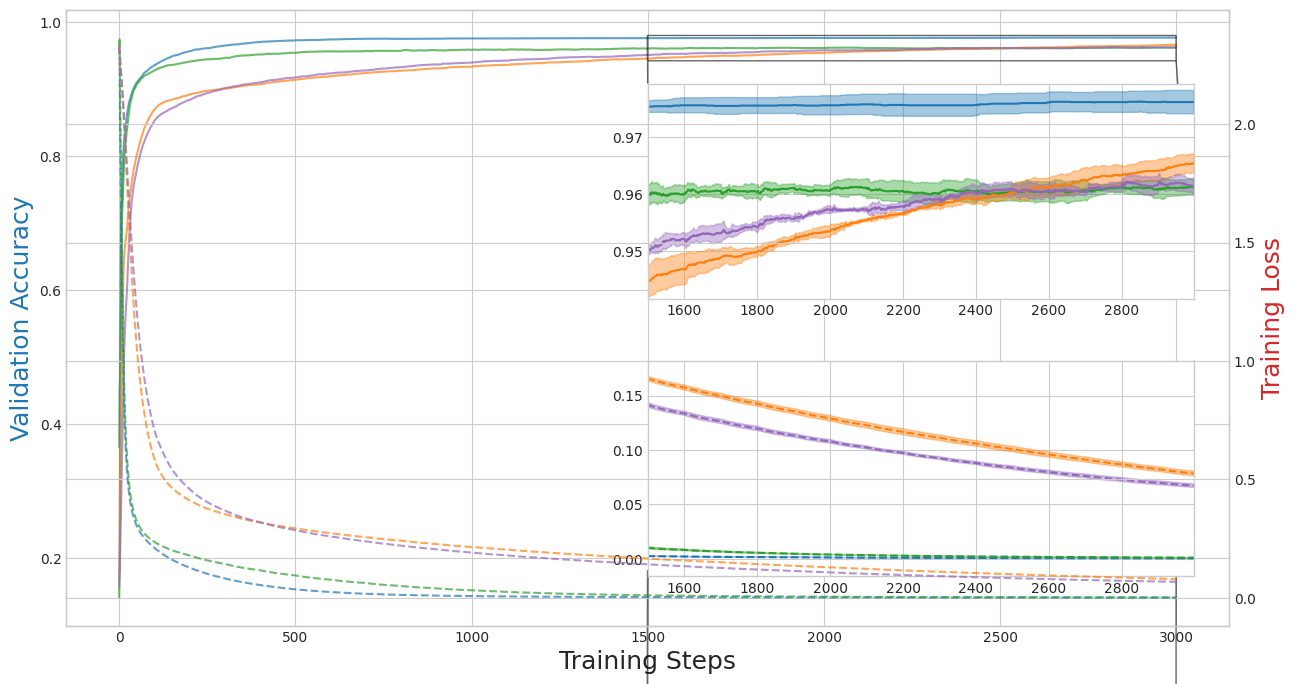

In [41]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.lines import Line2D # Used for creating custom legends

# --- Main Configuration ---

# 1. Set the base path to your results folder
BASE_RESULTS_PATH = pathlib.Path('results')

# 2. Define the optimizers you want to compare
OPTIMIZERS = ['adam', 'flora', 'floraAF', 'floraDR']

# 3. Define the random seeds for the runs you want to include
TESTED_SEEDS = [42, 123, 888]

# 4. Define the visual style for each optimizer
STYLES = {
    'adam':    {'color': '#1f77b4'}, # Blue
    'flora':   {'color': '#2ca02c'}, # Green
    'floraAF': {'color': '#ff7f0e'}, # Orange
    'floraDR': {'color': '#9467bd'}  # Purple
}
# Define distinct colors for the two y-axes
ACC_COLOR = 'tab:blue'
LOSS_COLOR = 'tab:red'


# --- 1. & 2. Data Aggregation and Processing ---
# This proven logic remains unchanged.
# (Condensed for brevity)
raw_data = defaultdict(lambda: {'accs': [], 'losses': []})
for optimizer in OPTIMIZERS:
    optimizer_path = BASE_RESULTS_PATH / optimizer
    if not optimizer_path.is_dir(): continue
    for seed in TESTED_SEEDS:
        run_dirs = list(optimizer_path.glob(f'*-seed_{seed}-*'))
        if not run_dirs: continue
        run_dir = run_dirs[0]
        acc_file, loss_file = run_dir / "validation_accs.npy", run_dir / "train_losses.npy"
        if acc_file.exists() and loss_file.exists():
            raw_data[optimizer]['accs'].append(np.load(acc_file))
            raw_data[optimizer]['losses'].append(np.load(loss_file))
plot_data = {}
for optimizer, data in raw_data.items():
    if not data['accs'] or not data['losses']: continue
    min_len = min(min(len(arr) for arr in data['accs']), min(len(arr) for arr in data['losses']))
    truncated_accs = [arr[:min_len] for arr in data['accs']]
    truncated_losses = [arr[:min_len] for arr in data['losses']]
    plot_data[optimizer] = {
        'x': np.arange(min_len), 'mean_acc': np.mean(truncated_accs, axis=0),
        'std_acc': np.std(truncated_accs, axis=0), 'mean_loss': np.mean(truncated_losses, axis=0),
        'std_loss': np.std(truncated_losses, axis=0)
    }


# --- 3. Plotting: Dual-Axis with Swapped Insets & External Legend ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()

# --- Plot Main Curves ---
for optimizer, data in plot_data.items():
    style = STYLES.get(optimizer, {})
    color = style.get('color')
    ax1.plot(data['x'], data['mean_acc'], label=optimizer, color=color, linestyle='-', alpha=0.7)
    ax2.plot(data['x'], data['mean_loss'], color=color, linestyle='--', alpha=0.7)

# --- Create and Plot on Insets (Positions swapped) ---
x1, x2 = int(plot_data['adam']['x'][-1] * 0.5), plot_data['adam']['x'][-1]
# Accuracy Inset (placed at the TOP)
axins_acc = ax1.inset_axes([0.5, 0.53, 0.47, 0.35])
# Loss Inset (placed at the BOTTOM)
axins_loss = ax1.inset_axes([0.5, 0.08, 0.47, 0.35])

for optimizer, data in plot_data.items():
    style = STYLES.get(optimizer, {})
    color = style.get('color')
    # Plot zoomed accuracy on the top inset
    axins_acc.plot(data['x'], data['mean_acc'], color=color, linestyle='-')
    axins_acc.fill_between(data['x'], data['mean_acc']-data['std_acc'], data['mean_acc']+data['std_acc'], color=color, alpha=0.4)
    # Plot zoomed loss on the bottom inset
    axins_loss.plot(data['x'], data['mean_loss'], color=color, linestyle='--')
    axins_loss.fill_between(data['x'], data['mean_loss']-data['std_loss'], data['mean_loss']+data['std_loss'], color=color, alpha=0.4)

# Set limits and indicators for the zoom
y1_acc = min(d['mean_acc'][x1:].min() for d in plot_data.values())
y2_acc = max(d['mean_acc'][x1:].max() for d in plot_data.values())
margin_acc = (y2_acc - y1_acc) * 0.1
axins_acc.set_xlim(x1, x2), axins_acc.set_ylim(y1_acc - margin_acc, y2_acc + margin_acc)
y1_loss = min(d['mean_loss'][x1:].min() for d in plot_data.values())
y2_loss = max(d['mean_loss'][x1:].max() for d in plot_data.values())
margin_loss = (y2_loss - y1_loss) * 0.1
axins_loss.set_xlim(x1, x2), axins_loss.set_ylim(y1_loss - margin_loss, y2_loss + margin_loss)
ax1.indicate_inset_zoom(axins_acc, edgecolor="black", alpha=0.6)
ax1.indicate_inset_zoom(axins_loss, edgecolor="black", alpha=0.6)

# --- Final Touches and Formatting ---
ax1.set_xlabel('Training Steps', fontsize=18)
ax1.set_ylabel('Validation Accuracy', fontsize=18, color=ACC_COLOR)
ax2.set_ylabel('Training Loss', fontsize=18, color=LOSS_COLOR)
ax1.tick_params(axis='y', labelcolor=ACC_COLOR)
ax2.tick_params(axis='y', labelcolor=LOSS_COLOR)
ax1.grid(True, linestyle='--', which='major', alpha=0.7)
axins_acc.grid(True, linestyle='--', linewidth=0.5), axins_loss.grid(True, linestyle='--', linewidth=0.5)

# --- NEW: Place Legend Just Outside the Plot Axes ---
# Get all handles and labels
optimizer_handles, _ = ax1.get_legend_handles_labels()
linestyle_handles = [Line2D([0], [0], color='gray', linestyle='-', label='Accuracy'),
                     Line2D([0], [0], color='gray', linestyle='--', label='Loss')]
all_handles = optimizer_handles + linestyle_handles

# Place legend outside the top-right corner of the plot area.
# bbox_to_anchor=(1.02, 1) means the legend's top-left corner is placed
# at a point 2% right of the plot's width and at the very top.
ax1.legend(handles=all_handles, loc='upper left', bbox_to_anchor=(1.02, 1.01), title="Legend", fontsize=15)

fig.suptitle('Convergence Analysis', fontsize=22)

# Use tight_layout to automatically adjust spacing. It will now
# account for the legend being part of the axes' bounding box.
fig.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle

fig.savefig('optimizer_comparison_final.pdf', bbox_inches='tight')
plt.show()